# Setup
This section contains all necessary setup such as libraries and model creation.

In [1]:
import numpy as np

from src.data.data_helper import get_raw_data_as_dataframe

In [2]:
raw_data = get_raw_data_as_dataframe()
raw_data.head()

,time,measurement,label,source
0,0.0000,1.650881,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
1,0.0002,1.654559,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
2,0.0004,1.650881,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
3,0.0006,1.654559,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
4,0.0008,1.654559,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...


In [3]:
raw_data.shape

(8030000, 4)

## Pre-processor Calibration
Due to the fact that all data needs to be pre-processed using the same bandpass filter and normalization the pre-processor needs to be calibrated. This is done by calculating the coefficients of the bandpass filter and the normalization parameters.

These parameters will then be passed to the selected model class.

In [4]:
from src.models.preprocessing.preprocessor import SignalPreprocessor

pre_processor = SignalPreprocessor(
    low_freq=20.0, # Maybe try down to 17.
    high_freq=500.0, # Around 100-150 looks good for our data.
    fs=5000.0,
    order=7
)

In [5]:
pre_processor.calibrate(raw_data)

## Data Parsing
This section deals with segmenting the data into usable segements with correct labeling. After that we pre-process the data using the pre-processor which is valibrated above. Once the data is pre-processed we apply one-hot encoding to the labels to allow for the use of F1 score. Finally we split the data into training and validation sets.

In [6]:
from src.data.data_helper import segement_data

In [7]:
segmented_data = segement_data(raw_data, window_length=200*5, overlap=50*5)

In [8]:
segmented_data.head()

,window_data,label,source
0,"[1.6508805694015458, 1.654558881124963, 1.6508...",0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
1,"[1.6435239459547115, 1.6435239459547115, 1.643...",0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
2,"[1.6361673225078774, 1.6361673225078774, 1.636...",0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
3,"[1.647202257678129, 1.647202257678129, 1.65088...",0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
4,"[1.6435239459547115, 1.6435239459547115, 1.643...",0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...


In [9]:
segmented_data.iloc[1000]

window_data    [1.952502130721748, 1.952502130721748, 1.94882...
label                                                          2
source         C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
Name: 1000, dtype: object

In [10]:
num_classes = segmented_data['label'].nunique()
num_classes

4

In [11]:
import tensorflow as tf

y_data = np.array(segmented_data['label'].values)
y_data = tf.keras.utils.to_categorical(y_data, num_classes=num_classes)

# I apologize for this horrible line. Can be fixed by fixing the data_helper
X_data = np.stack(segmented_data.drop(columns=['label', 'source'])['window_data'].values)

In [12]:
X_data.shape

(10658, 1000)

In [13]:
X_data = pre_processor.batch_pre_process(X_data)
X_data.shape

(10658, 1000)

In [14]:
y_data.shape

(10658, 4)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
        X_data, y_data, test_size=0.2
    )

In [16]:
X_train.shape

(8526, 1000)

In [17]:
X_val.shape

(2132, 1000)

## Analysis and Fixing of Imblanaces in Labels

In [18]:
label_percentages = segmented_data['label'].value_counts(normalize=True).sort_index() * 100
print(label_percentages)

label
0    55.029086
1     4.325389
2    36.254457
3     4.391068
Name: proportion, dtype: float64


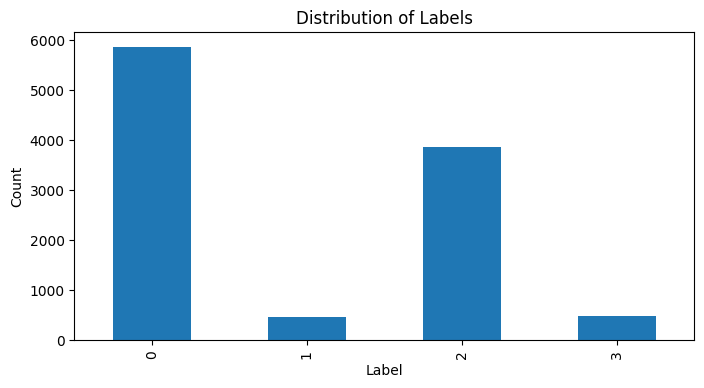

In [19]:
import matplotlib.pyplot as plt

# Plot label distribution
plt.figure(figsize=(8, 4))
segmented_data['label'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

In [20]:
labels = np.argmax(y_train, axis=1)
unique, counts = np.unique(labels, return_counts=True)

In [21]:
labels.shape[0]

8526

In [22]:
unique

array([0, 1, 2, 3])

In [23]:
counts

array([4698,  367, 3092,  369])

In [24]:
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / counts[0]) * (labels.shape[0] / 2.0)
weight_for_1 = (1 / counts[1]) * (labels.shape[0] / 2.0)
weight_for_2 = (1 / counts[2]) * (labels.shape[0] / 2.0)
weight_for_3 = (1 / counts[3]) * (labels.shape[0] / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}
class_weight

{0: np.float64(0.9074074074074074),
 1: np.float64(11.615803814713896),
 2: np.float64(1.3787192755498061),
 3: np.float64(11.552845528455284)}

In [25]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# ros = RandomOverSampler(random_state=0)
# ros = RandomUnderSampler(random_state=0)
# smote = SMOTE(random_state=0)

# X_train, y_train = ros.fit_resample(X_train, y_train)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [26]:
X_train.shape

(8526, 1000)

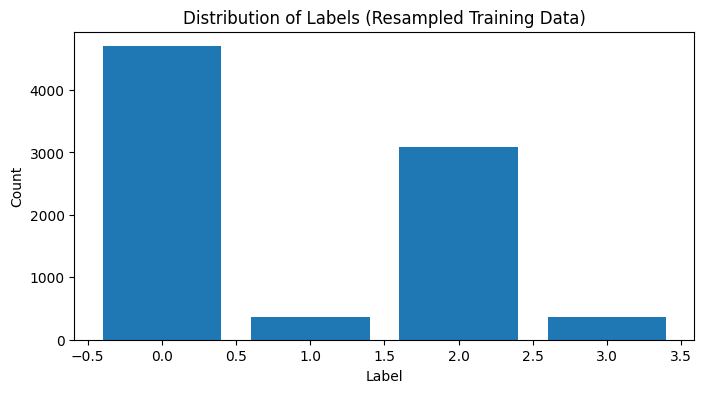

In [27]:
# Plot label distribution for resampled training data
plt.figure(figsize=(8, 4))
labels_resampled = np.argmax(y_train, axis=1)
unique, counts = np.unique(labels_resampled, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels (Resampled Training Data)')
plt.show()

In [28]:
X_train.shape

(8526, 1000)

In [29]:
X_val.shape

(2132, 1000)

# Model Setup
Import model classes and create instances of the models.

## Hyperparameters

In [30]:
batch_size = 256
epochs = 20

learning_rate = 1e-3

## Model Creation

In [31]:
from src.models.LSTM.LSTM import LSTM
from src.models.LSTM_STFT.LSTM_STFT import LSTM_STFT
from src.models.LSTM_STFT_Dense.LSTM_STFT_Dense import LSTM_STFT_Dense

In [32]:
LSTM_model = LSTM(
    input_shape=X_data.shape[1],
    num_classes=num_classes,
    learning_rate=learning_rate
)

In [33]:
LSTM_STFT_model = LSTM_STFT(
    input_shape=X_data.shape[1],
    num_classes=num_classes,
    learning_rate=learning_rate
)

In [34]:
LSTM_STFT_Dense_model = LSTM_STFT_Dense(
    input_shape=X_data.shape[1],
    num_classes=num_classes,
    learning_rate=learning_rate
)

# Train Model
Train the models

In [35]:
LSTM_model.get_model().fit(X_train, y_train,
                       validation_data=(X_val, y_val),
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=2,
                       class_weight=class_weight
                    )

Epoch 1/20
34/34 - 3s - 81ms/step - f1_score: 0.2917 - loss: 2.5368 - val_f1_score: 0.4368 - val_loss: 1.1720
Epoch 2/20
34/34 - 0s - 14ms/step - f1_score: 0.5252 - loss: 2.0405 - val_f1_score: 0.5691 - val_loss: 0.7442
Epoch 3/20
34/34 - 0s - 14ms/step - f1_score: 0.5492 - loss: 1.6929 - val_f1_score: 0.4629 - val_loss: 0.5825
Epoch 4/20
34/34 - 0s - 14ms/step - f1_score: 0.5442 - loss: 1.6300 - val_f1_score: 0.5652 - val_loss: 0.5544
Epoch 5/20
34/34 - 0s - 14ms/step - f1_score: 0.5626 - loss: 1.6237 - val_f1_score: 0.5599 - val_loss: 0.7439
Epoch 6/20
34/34 - 1s - 15ms/step - f1_score: 0.5746 - loss: 1.6236 - val_f1_score: 0.5583 - val_loss: 0.5595
Epoch 7/20
34/34 - 1s - 16ms/step - f1_score: 0.5869 - loss: 1.5993 - val_f1_score: 0.6022 - val_loss: 0.5477
Epoch 8/20
34/34 - 0s - 14ms/step - f1_score: 0.5755 - loss: 1.5878 - val_f1_score: 0.6018 - val_loss: 0.5431
Epoch 9/20
34/34 - 0s - 14ms/step - f1_score: 0.5535 - loss: 1.6029 - val_f1_score: 0.5975 - val_loss: 0.5506
Epoch 10/2

In [36]:
LSTM_STFT_model.get_model().fit(X_train, y_train,
                       validation_data=(X_val, y_val),
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=2,
                       class_weight=class_weight
                    )

Epoch 1/20
34/34 - 2s - 68ms/step - f1_score: 0.4921 - loss: 2.1087 - val_f1_score: 0.4963 - val_loss: 0.7102
Epoch 2/20
34/34 - 0s - 11ms/step - f1_score: 0.5308 - loss: 1.7047 - val_f1_score: 0.5791 - val_loss: 0.5840
Epoch 3/20
34/34 - 1s - 18ms/step - f1_score: 0.5714 - loss: 1.6485 - val_f1_score: 0.5589 - val_loss: 0.6245
Epoch 4/20
34/34 - 1s - 17ms/step - f1_score: 0.5821 - loss: 1.6180 - val_f1_score: 0.5546 - val_loss: 0.5637
Epoch 5/20
34/34 - 1s - 15ms/step - f1_score: 0.5666 - loss: 1.5876 - val_f1_score: 0.5883 - val_loss: 0.5116
Epoch 6/20
34/34 - 0s - 12ms/step - f1_score: 0.5705 - loss: 1.5738 - val_f1_score: 0.5737 - val_loss: 0.5274
Epoch 7/20
34/34 - 0s - 11ms/step - f1_score: 0.5911 - loss: 1.5838 - val_f1_score: 0.5557 - val_loss: 0.5953
Epoch 8/20
34/34 - 1s - 18ms/step - f1_score: 0.5963 - loss: 1.5623 - val_f1_score: 0.5858 - val_loss: 0.5431
Epoch 9/20
34/34 - 1s - 15ms/step - f1_score: 0.5781 - loss: 1.5551 - val_f1_score: 0.5762 - val_loss: 0.5448
Epoch 10/2

In [37]:
LSTM_STFT_Dense_model.get_model().fit(X_train, y_train,
                       validation_data=(X_val, y_val),
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=2,
                       class_weight=class_weight
                    )

Epoch 1/20
34/34 - 3s - 74ms/step - f1_score: 0.3730 - loss: 2.5479 - val_f1_score: 0.5355 - val_loss: 1.0347
Epoch 2/20
34/34 - 1s - 16ms/step - f1_score: 0.5506 - loss: 1.9231 - val_f1_score: 0.5505 - val_loss: 0.6254
Epoch 3/20
34/34 - 1s - 18ms/step - f1_score: 0.5549 - loss: 1.6589 - val_f1_score: 0.5656 - val_loss: 0.5886
Epoch 4/20
34/34 - 1s - 15ms/step - f1_score: 0.5480 - loss: 1.6288 - val_f1_score: 0.4937 - val_loss: 0.6400
Epoch 5/20
34/34 - 1s - 17ms/step - f1_score: 0.5736 - loss: 1.6065 - val_f1_score: 0.5970 - val_loss: 0.5441
Epoch 6/20
34/34 - 1s - 15ms/step - f1_score: 0.5638 - loss: 1.6002 - val_f1_score: 0.5846 - val_loss: 0.5309
Epoch 7/20
34/34 - 1s - 17ms/step - f1_score: 0.5766 - loss: 1.5674 - val_f1_score: 0.5248 - val_loss: 0.5595
Epoch 8/20
34/34 - 0s - 15ms/step - f1_score: 0.5779 - loss: 1.5664 - val_f1_score: 0.6045 - val_loss: 0.4969
Epoch 9/20
34/34 - 1s - 15ms/step - f1_score: 0.5839 - loss: 1.5838 - val_f1_score: 0.5918 - val_loss: 0.5760
Epoch 10/2

# Plotting

In [38]:
from src.visualizations.plot_learning_curves import plot_learning_curves, plot_confusion_and_f1

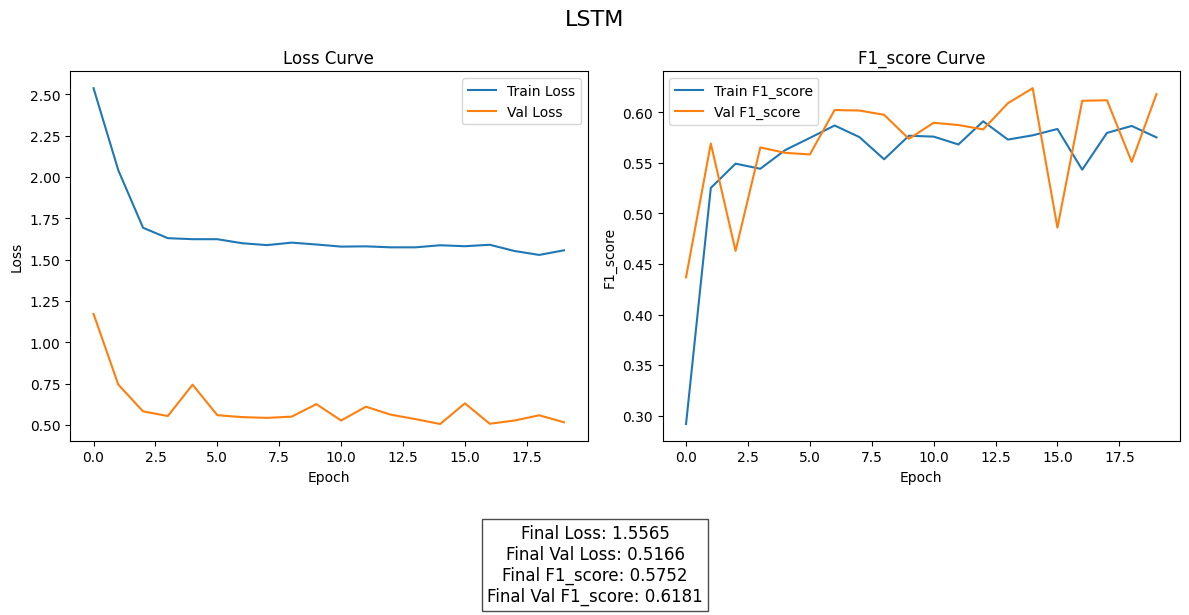

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


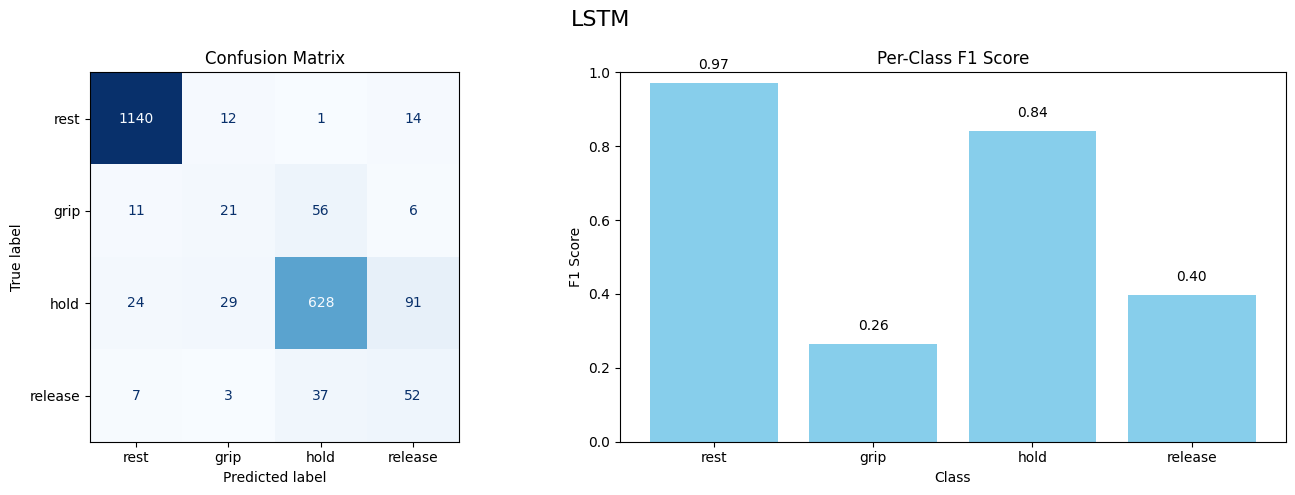

In [39]:
plot_learning_curves(LSTM_model.get_model(), plot_title=LSTM_model.get_model_name())
plot_confusion_and_f1(LSTM_model.get_model(), X_val, y_val, plot_title=LSTM_model.get_model_name())

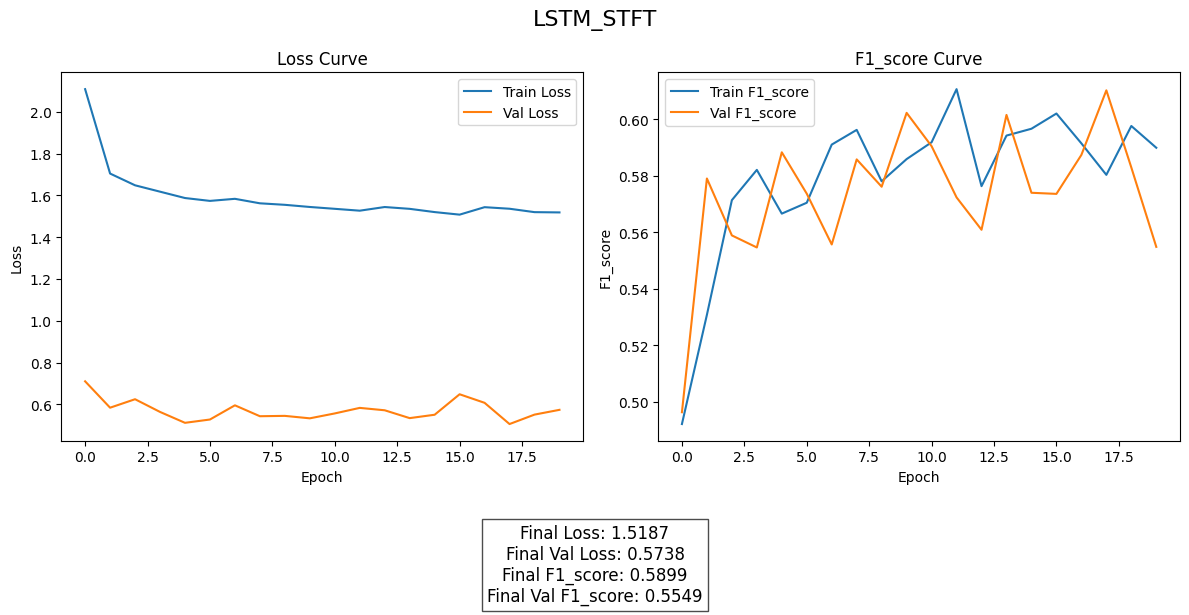

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


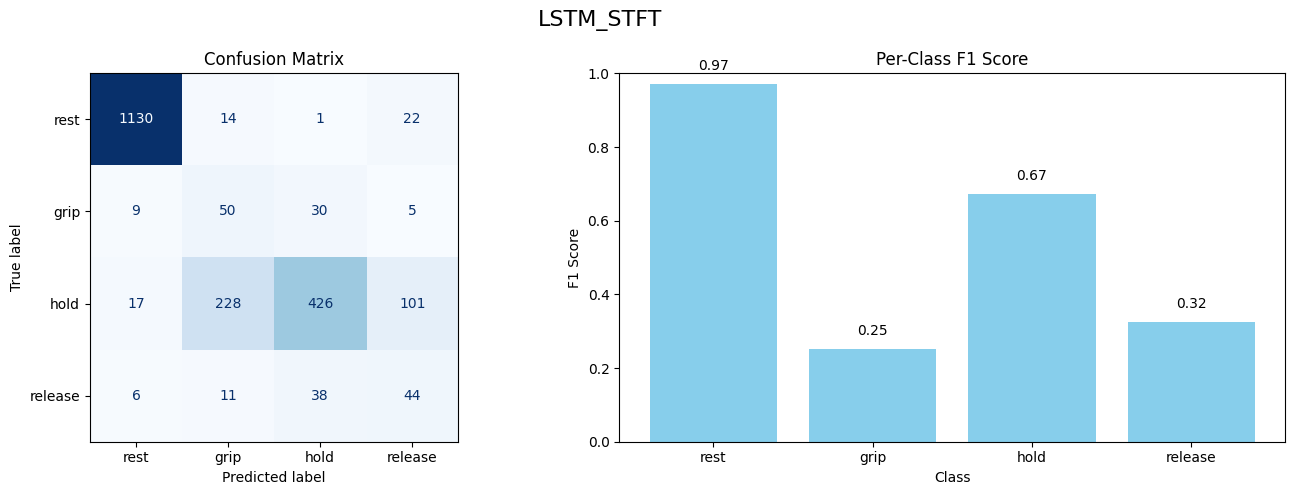

In [40]:
plot_learning_curves(LSTM_STFT_model.get_model(), plot_title=LSTM_STFT_model.get_model_name())
plot_confusion_and_f1(LSTM_STFT_model.get_model(), X_val, y_val, plot_title=LSTM_STFT_model.get_model_name())

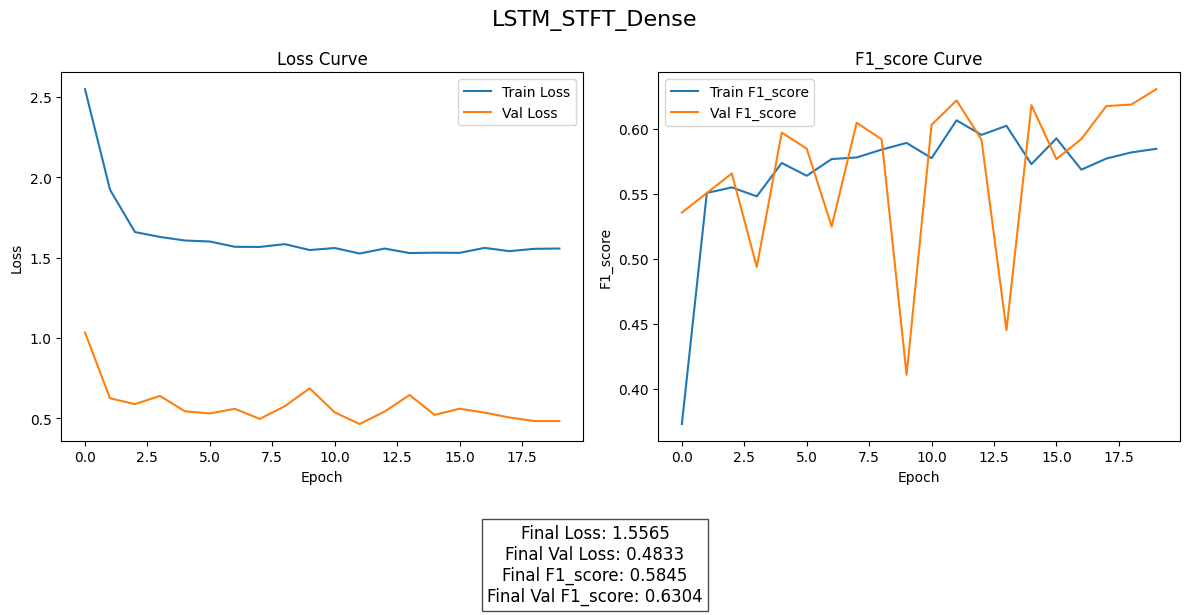

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


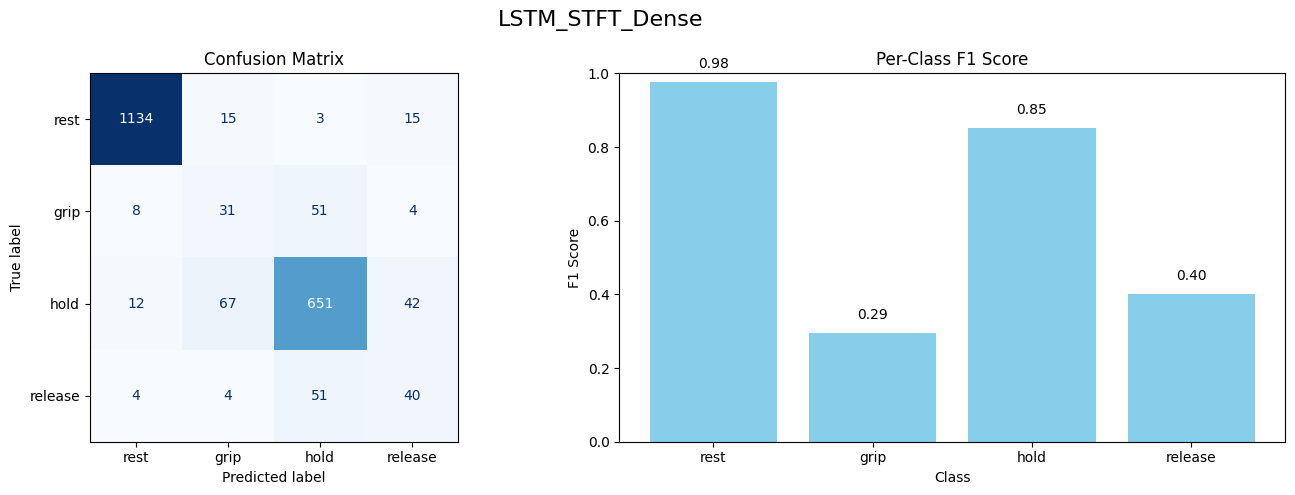

In [41]:
plot_learning_curves(LSTM_STFT_Dense_model.get_model(), plot_title=LSTM_STFT_Dense_model.get_model_name())
plot_confusion_and_f1(LSTM_STFT_Dense_model.get_model(), X_val, y_val, plot_title=LSTM_STFT_Dense_model.get_model_name())